In [1]:
# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4" #"1"
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Hypothesis Testing Circuits

The primary tests we want to replicate are the faithfulness test (Equiavelance) and the minimality test (Minimality)

Faithfulness Test
- the full model and ablated model are equally likely to outpeform each other on a task
    - probability of the delta of the score function is greater then 0 - 1/2 is less than epsilon
    - use a sign test
    - test statistic is the # of times C* and M outperform each other 
    - test statistic is absolue value of the difference between the mean that the ablated model outpeforms the original model and 1/2
- P value (value of test statistic such that P(T > T_obs) = alpha) given by binomial distribution P(K > (T_obs + 1/2) * n | \theta = (1/2) + \epsilon)
    how do we choose epsilon?
    set to 0.1



# Minimal Faithful Circuit According to Attribution Score Ordering

In [21]:
from typing import Callable, Dict, Tuple, Union, Optional, Any, Literal, NamedTuple
from itertools import product
from copy import deepcopy
import random
import math

import torch
import numpy as np
from scipy.stats import binom, beta

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

from transformer_lens import HookedTransformer

from auto_circuit.types import (
    CircuitOutputs, 
    BatchKey,
    PruneScores,
    PatchType, 
    AblationType,
    SrcNode, 
    DestNode, 
    Edge
)
from auto_circuit.data import PromptPairBatch, PromptDataLoader   
from auto_circuit.prune_algos.mask_gradient import mask_gradient_prune_scores
from auto_circuit.tasks import (
    Task,
    DOCSTRING_COMPONENT_CIRCUIT_TASK, 
    DOCSTRING_TOKEN_CIRCUIT_TASK,
    IOI_COMPONENT_CIRCUIT_TASK, 
    IOI_TOKEN_CIRCUIT_TASK,
    IOI_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK,
    GREATERTHAN_COMPONENT_CIRCUIT_TASK,  
    GREATERTHAN_GPT2_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    CAPITAL_CITIES_PYTHIA_70M_AUTOENCODER_COMPONENT_CIRCUIT_TASK, 
    docstring_true_edges
)
from auto_circuit.visualize import draw_seq_graph
from auto_circuit.utils.tensor_ops import batch_answer_diffs, batch_avg_answer_val
from auto_circuit.utils.patchable_model import PatchableModel
from auto_circuit.utils.custom_tqdm import tqdm

from elk_experiments.auto_circuit.auto_circuit_utils import (
    run_circuits,
    desc_prune_scores, 
    prune_scores_threshold, 
    load_tf_model
)
from elk_experiments.auto_circuit.score_funcs import GradFunc, AnswerFunc, get_score_func

from elk_experiments.auto_circuit.circuit_hypotests import (
    equiv_test,
    sweep_search_smallest_equiv,
    plot_equivs_bar, 
    plot_num_ablated_C_gt_M, 
    plot_circuit_and_model_scores,
    compute_knees, 
    plot_edge_scores_and_knees,
    create_paths, 
    minimality_test, 
    plot_p_values, 
    plot_edge_k, 
    plot_score_quantiles
)
from elk_experiments.auto_circuit.circuit_hypotests import (
    get_edge_idx,
    make_complement_paths, 
    edges_from_mask, 
    minimality_test
)

In [3]:

DOCSTRING_PYTHIA_70M_AUTOENCODER_COMPONENT_CIRCUIT_TASK: Task = Task(
    key="Docstring Component Circuit",
    name="Docstring",
    _model_def="pythia-70m-deduped",
    _dataset_name="docstring_prompts",
    batch_size=2,
    batch_count=128,
    _true_edge_func=None,
    token_circuit=False,
    autoencoder_input="resid_delta_mlp",
    autoencoder_max_latents=200,
    autoencoder_pythia_size="2_32768",
    autoencoder_prune_with_corrupt=False,
)

In [8]:
300 / 12

25.0

In [9]:
from auto_circuit.metrics.official_circuits.circuits.ioi_official import (
    ioi_head_based_official_edges,
    ioi_true_edges,
)
IOI_TOKEN_CIRCUIT_TASK: Task = Task(
    key="Indirect Object Identification Token Circuit",
    name="Indirect Object Identification",
    _model_def="gpt2-small",
    _dataset_name="ioi/ioi_vanilla_template_prompts",
    batch_size=(60, 20),
    batch_count=(5, 5),
    _true_edge_func=ioi_head_based_official_edges,
    token_circuit=True,
)

In [10]:
task = IOI_TOKEN_CIRCUIT_TASK
token = True

task.init_task()

# docstring_task = DOCSTRING_COMPONENT_CIRCUIT_TASK
ablation_type = AblationType.TOKENWISE_MEAN_CLEAN_AND_CORRUPT
clean_corrupt = "corrupt" if ablation_type == AblationType.RESAMPLE else None 
alpha = 0.05
epsilon = 0.1 
q_star = 0.9
use_abs = False
side = None if use_abs else "left"
grad_function = GradFunc.LOGPROB
answer_function = AnswerFunc.AVG_VAL
grad_function_attrib = GradFunc.LOGPROB
answer_function_attrib = AnswerFunc.AVG_VAL

seq_len before divergence 15
seq_len after divergence 13


In [11]:
# compute edge scores
# TODO: pass full model
attribution_scores = mask_gradient_prune_scores(
    model=task.model, 
    dataloader=task.train_loader,
    official_edges=None,
    grad_function=grad_function_attrib.value, #grad_function,
    answer_function=answer_function_attrib.value, #answer_function,
    mask_val=None, 
    ablation_type=ablation_type,
    integrated_grad_samples=10, # 10 1 for debugging
    clean_corrupt=clean_corrupt,
)

In [6]:
# # set all masks
# # patch mode
# # patch 
# from auto_circuit.utils.ablation_activations import src_ablations, batch_src_ablations
# from auto_circuit.utils.graph_utils import set_all_masks, patch_mode
# from copy import deepcopy

# ref_model = deepcopy(task.model)

# logit_diffs = []
# sae_diffs = []
# model_diffs = []
# set_all_masks(task.model, 1.0) # ablate all edges
# patch_outs = batch_src_ablations(task.model, task.test_loader, ablation_type, clean_corrupt)
# score_func = get_score_func(grad_function, answer_function)
# for batch in task.test_loader:
#     with patch_mode(task.model, patch_outs[batch.key]), torch.inference_mode():
#         sae_out = task.model(batch.clean)[:, -1]
#     model_out = ref_model(batch.clean)[:,-1]
#     sae_diff = score_func(sae_out, batch)
#     model_diff = score_func(model_out, batch)
#     sae_diffs.append(sae_diff)
#     model_diffs.append(model_diff)
#     logit_diffs.append(sae_diff - model_diff)
# set_all_masks(task.model, 0.0)
# torch.mean((torch.stack(logit_diffs) >= 0).to(torch.float))

In [12]:
test_results, min_equiv = sweep_search_smallest_equiv(
    task.model, 
    task.test_loader,
    attribution_scores,
    grad_function, 
    answer_function,
    ablation_type=ablation_type,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon if use_abs else 0.0,
)

interval: 0 - 422383
width 10000


interval: 0 - 10000
width 1000


interval: 0 - 1000
width 100


interval: 0 - 100
width 10


interval: 60 - 70
width 1


In [13]:
assert min_equiv == min([k for k, v in test_results.items() if not v.not_equiv])
min_equiv

65

In [14]:
threshold = prune_scores_threshold(attribution_scores, min_equiv, use_abs=use_abs)
edge_mask = {k: torch.abs(v) if use_abs else v >= threshold for k, v in attribution_scores.items()}
edges = edges_from_mask(task.model.srcs, task.model.dests, edge_mask, token=token)


In [15]:
# accuracy, true positive
overlap = set(edges) & set(task.true_edges)
acc = len(overlap) / task.true_edge_count
tp = len(overlap) / len(edges)
acc, tp

(0.0012824235385210994, 0.8153846153846154)

In [16]:
from auto_circuit.types import Node
from collections import defaultdict

NodeIdx = Tuple[int, int] # layer, head
def get_node_idx(node: DestNode) -> NodeIdx:
    return (node.layer, node.head_idx)

# create edge dicts by src and dest
edges_by_dest: dict[NodeIdx, list[Edge]] = defaultdict(list)
edges_by_src: dict[NodeIdx, list[Edge]] = defaultdict(list)
for edge in edges:
    edges_by_dest[get_node_idx(edge.dest)].append(edge)
    edges_by_src[get_node_idx(edge.src)].append(edge)
# creates edges to dest list
edges_to_dest: list[Edge] = []
# create edges to check queue
edges_to_check: list[Edge] = []
# add all edges with dest at resid end to edges to check
resid_end = next((dest for dest in task.model.dests if dest.name == "Resid End"), None)
edges_to_check.extend(edges_by_dest[get_node_idx(resid_end)])
checked: set[Node] = set()
# while len(edges_to_check) > 0
#TODO: should treat k,q, v separately (i.e query is only conecting if following edge is in same sequence pos, whereas k and v can connect to any edge)
while len(edges_to_check) > 0:
    edge = edges_to_check.pop(0)
    # add edge to edges to dest
    edges_to_dest.append(edge)
    # get all edges with dest as src and add to edges to check (if not already chchedk)
    if edge.src in checked:
        continue
    for edge_to_check in edges_by_dest[get_node_idx(edge.src)]:
        # filter for queries not in same sequence 
        if edge_to_check.dest.name.endswith("Q") and edge.seq_idx != edge_to_check.seq_idx:
            continue
        edges_to_check.append(edge_to_check)
    checked.add(edge.src)
print(len(edges_to_dest), len(edges))


40 65


In [17]:
[(edge.src.name, edge.dest.name, edge.seq_idx) for edge in set(edges) - set(edges_to_dest)]

[('MLP 3', 'MLP 5', 8),
 ('A4.11', 'A5.5.K', 3),
 ('MLP 0', 'MLP 6', 0),
 ('MLP 0', 'MLP 3', 0),
 ('A10.7', 'A11.10.Q', 12),
 ('Resid Start', 'A0.1.V', 0),
 ('MLP 0', 'A11.9.V', 0),
 ('Resid Start', 'A0.10.Q', 8),
 ('Resid Start', 'A0.3.V', 0),
 ('Resid Start', 'A0.10.K', 2),
 ('Resid Start', 'A0.10.K', 8),
 ('MLP 2', 'A3.0.Q', 8),
 ('A1.8', 'A7.9.K', 8),
 ('Resid Start', 'A0.4.V', 0),
 ('MLP 0', 'MLP 7', 0),
 ('MLP 0', 'A3.0.K', 2),
 ('MLP 0', 'A1.11.Q', 8),
 ('Resid Start', 'A0.1.Q', 0),
 ('MLP 0', 'A3.0.Q', 8),
 ('MLP 0', 'A5.5.Q', 8),
 ('MLP 0', 'MLP 5', 0),
 ('MLP 0', 'MLP 4', 0),
 ('A3.4', 'MLP 4', 8),
 ('MLP 0', 'MLP 8', 0),
 ('Resid Start', 'A0.1.K', 0)]

In [18]:
def get_edge_idx(edge: Edge):
    if edge.dest.name == "Resid End":
        return (edge.src.src_idx,)
    return (edge.seq_idx, edge.dest.head_idx, edge.src.src_idx)

In [19]:
# mask out all edges not in edges to dest
dead_end_score_mask = deepcopy(attribution_scores)
for edge in set(edges) - set(edges_to_dest):
    dead_end_score_mask[edge.dest.module_name][get_edge_idx(edge)] = 0.0

In [22]:
# from elk_experiments.auto_circuit.circuit_hypotests import equiv_test
# recompute equivalence 
pruned_result = equiv_test(
    task.model, 
    task.test_loader,
    dead_end_score_mask,
    grad_function,
    answer_function,
    ablation_type,
    thresholds=[threshold],
    model_out=None,
    full_model=None,
    use_abs=use_abs,
    side=side,
    alpha=alpha,
    epsilon=epsilon,
)[len(edges_to_dest)]

In [23]:
assert not pruned_result.not_equiv
assert torch.allclose(pruned_result.circ_scores, test_results[len(edges)].circ_scores, atol=1e-5)

In [25]:
fig = draw_seq_graph(
    model=task.model,
    prune_scores=attribution_scores,
    score_threshold=prune_scores_threshold(attribution_scores, min_equiv, use_abs=use_abs),
    show_all_seq_pos=True,
    orientation="h",
    use_abs=False,
    seq_labels=task.train_loader.seq_labels,
)

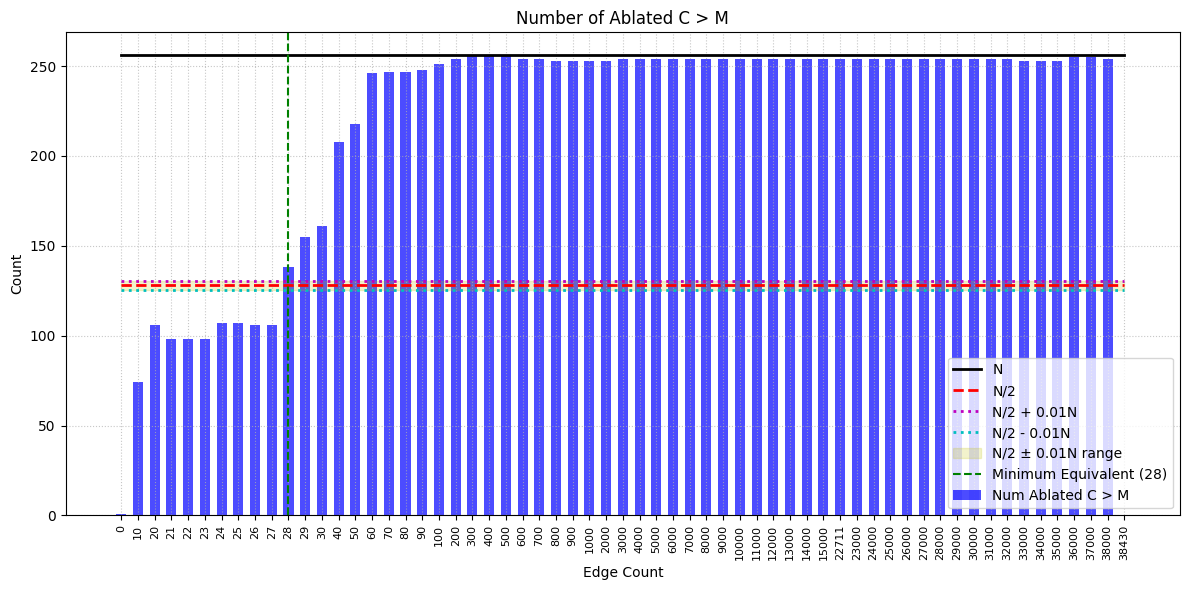

In [73]:
fig, ax = plot_num_ablated_C_gt_M(test_results, epsilon=epsilon if use_abs else 0.01, min_equiv=min_equiv)

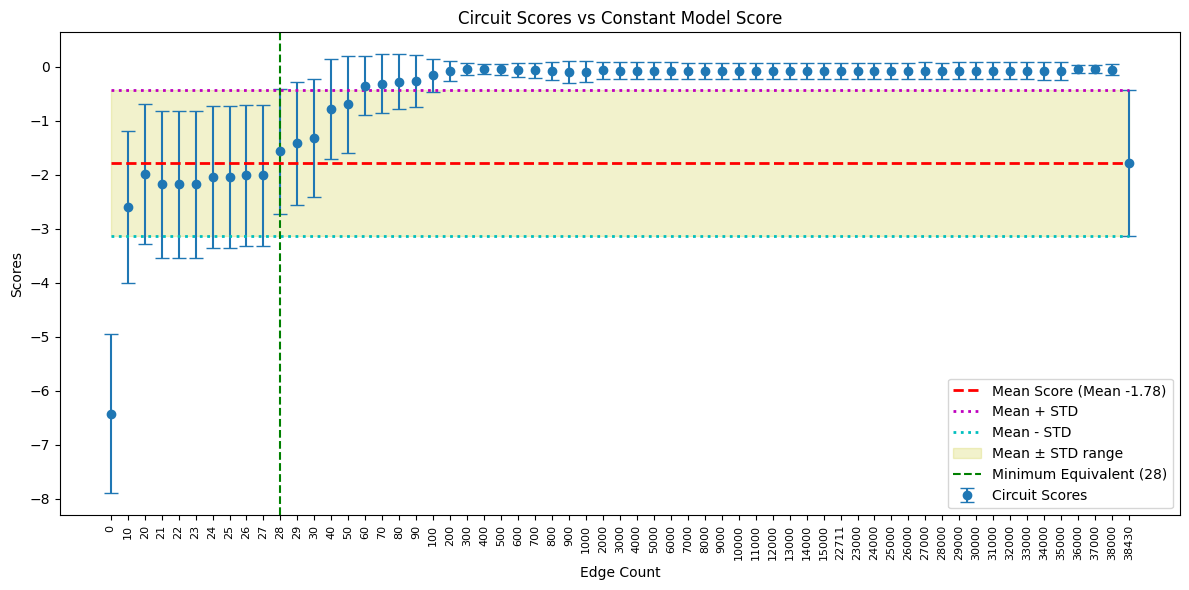

In [72]:
fig, ax = plot_circuit_and_model_scores(test_results, min_equiv)

In [60]:
def plot_edge_scores_and_knees(edge_scores, kneedle_poly, kneedle_1d, min_equiv):
    fig, ax = plt.subplots()
    ax.plot(edge_scores)
    # log axis 
    ax.set_yscale('log')
    ax.axvline(kneedle_poly.knee, color='r', linestyle='--', label="knee poly")
    ax.axvline(kneedle_1d.knee, color='g', linestyle='--', label="knee 1d")
    # plot min_equiv 
    ax.axvline(len(edge_scores) - min_equiv, color='b', linestyle='--', label="min equiv")
    ax.legend()
    return fig, ax

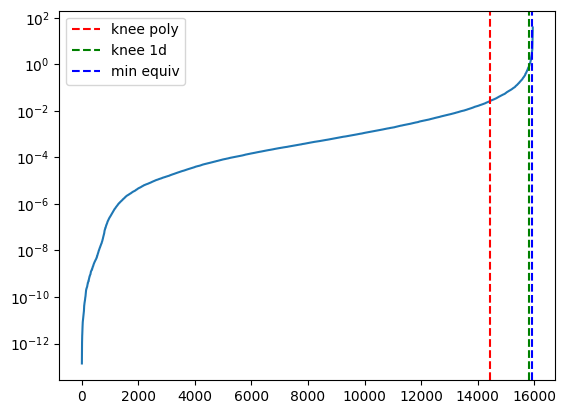

In [61]:
# plot attribution scores 
import numpy as np
edge_scores = np.flip(desc_prune_scores(attribution_scores, use_abs=use_abs).detach().cpu().numpy())
if not use_abs:
    edge_scores = edge_scores[edge_scores > 0]
kneedle_poly, kneedle_1d = compute_knees(edge_scores)
fig, ax = plot_edge_scores_and_knees(edge_scores, kneedle_poly, kneedle_1d, min_equiv)

In [62]:
round(len(edge_scores) - kneedle_poly.knee), round(len(edge_scores) - kneedle_1d.knee), min_equiv

(1526, 143, 28)

# Minimality Test

In [9]:
task.model.cfg.n_layers

12

In [76]:
[edge.seq_idx for edge in task.model.edges if edge.dest.name == "Resid End"]

[2,
 9,
 24,
 20,
 10,
 13,
 16,
 14,
 15,
 2,
 8,
 19,
 7,
 19,
 26,
 26,
 14,
 16,
 6,
 24,
 18,
 14,
 20,
 10,
 3,
 18,
 19,
 6,
 24,
 1,
 4,
 0,
 23,
 11,
 27,
 3,
 23,
 18,
 10,
 22,
 18,
 14,
 14,
 23,
 10,
 28,
 6,
 8,
 4,
 27,
 15,
 0,
 25,
 22,
 14,
 15,
 26,
 18,
 18,
 3,
 14,
 10,
 0,
 22,
 12,
 8,
 1,
 4,
 2,
 3,
 8,
 29,
 7,
 19,
 22,
 7,
 19,
 14,
 14,
 2,
 4,
 26,
 6,
 2,
 8,
 6,
 7,
 12,
 11,
 29,
 29,
 23,
 15,
 11,
 23,
 18,
 6,
 10,
 2,
 2,
 11,
 16,
 24,
 15,
 22,
 3,
 19,
 27,
 19,
 27,
 22,
 13,
 10,
 3,
 14,
 6,
 6,
 20,
 28,
 10,
 0,
 26,
 23,
 23,
 17,
 28,
 7,
 10,
 7,
 2,
 19,
 2,
 14,
 18,
 27,
 22,
 0,
 21,
 17,
 17,
 11,
 3,
 11,
 6,
 23,
 18,
 22,
 26,
 29,
 4,
 12,
 27,
 3,
 10,
 21,
 21,
 7,
 7,
 15,
 10,
 1,
 27,
 12,
 2,
 29,
 26,
 27,
 16,
 14,
 25,
 25,
 11,
 11,
 5,
 16,
 1,
 23,
 7,
 27,
 20,
 2,
 23,
 18,
 6,
 21,
 15,
 28,
 10,
 9,
 20,
 5,
 5,
 27,
 11,
 6,
 27,
 23,
 10,
 25,
 21,
 14,
 17,
 0,
 15,
 24,
 9,
 9,
 3,
 15,
 0,
 20,
 27,
 17,
 14

In [78]:
max_seq_idx = max([edge.seq_idx for edge in task.model.edges if edge.dest.name == "Resid End"])
max_seq_idx

29

In [95]:
max_layer

5

In [97]:
from collections import defaultdict
last_seq_idx = max([src.seq_idx for src in task.model.edges])
srcs = task.model.srcs
dests = task.model.dests
max_layer = max([dest.layer for dest in dests])
# hmm I think sampling a path is exactly the smae

# screen out edges with dest layers 
# filter out edges to resid end that are not in last sequence
valid_edges = [edge for edge in task.model.edges if 
               not (edge.dest.name == "Resid End" and edge.seq_idx != last_seq_idx) and 
               (edge.dest.layer < max_layer - 3 or edge.seq_idx == last_seq_idx or edge.dest.name.endswith(("K", "V")))]

# get edges by src and dest
edges_by_dest_idx: dict[NodeIdx, list[Edge]] = defaultdict(list)
edges_by_src_idx: dict[NodeIdx, list[Edge]] = defaultdict(list)
for edge in valid_edges:
    edges_by_dest_idx[get_node_idx(edge.dest)].append(edge)
    edges_by_src_idx[get_node_idx(edge.src)].append(edge)

In [125]:
# iteratively sample a path 
def sample_path():
    cur_edge = random.choice([edge for edge in valid_edges if edge.src.name == "Resid Start"])
    path = [cur_edge]
    while cur_edge.dest.name != "Resid End":
        if cur_edge.dest.name.endswith(('K', 'V')):
            next_edges = edges_by_src_idx[get_node_idx(cur_edge.dest)]
        else: # mlp or query 
            next_edges = [edge for edge in edges_by_src_idx[get_node_idx(cur_edge.dest)] if edge.seq_idx == cur_edge.seq_idx]
            # if len(next_edges) == 0:
            #     raise ValueError(f"no edge found for {cur_edge.dest.name} {cur_edge.seq_idx}")
        next_edge = random.choice(next_edges)
        path.append(next_edge)
        cur_edge = next_edge
    return path

In [128]:
paths = [sample_path() for _ in range(100)]
sorted_paths = sorted(paths, key=lambda path: len(path))

In [131]:
[edge.seq_idx for edge in sorted_paths[-1]]

[26, 26, 0, 20, 29]

In [ ]:

# construct paths as lists of start node edges 
start_node = next((src for src in srcs if src.name == "Resid Start"), None)
paths: list[list[Edge]] = [[edge] for edge in edges_by_src_idx[get_node_idx(start_node)]]
# construct paths
complete_paths = []
while len(paths) > 0: 
    path = paths.pop(0)
    # get last edge
    last_edge = path[-1]
    # if dest node is resid end, add path to complete paths, 
    if last_edge.dest.name == "Resid End":
        complete_paths.append(path)
        continue
    # edge edges with start node corresponding to dest node
    next_edges = edges_by_src_idx[get_node_idx(last_edge.dest)]
    # filter 
    # if dest node is attention head with k, v, 
    if last_edge.dest.name.endswith(("K", "V")): 
        # create new paths adding each edge 
        for next_edge in next_edges:
            paths.append(path + [next_edge])
    else: #(dest node is attention head with q or mlp)
        # find next nedge with same seq_idx
        next_edge = next((edge for edge in next_edges if edge.seq_idx == last_edge.seq_idx), None)
        # if found, add to path
        if next_edge is not None:
            paths.append(path + [next_edge])

In [83]:
completed_paths

NameError: name 'completed_paths' is not defined

In [ ]:

    
    
    # else 
        # filter for edge with same seq_idx

# so if I started the other way I would 
# start with root node 
# find all edges with src as root node
# for each dest in edges, find all edges with dest as src
    # for attention keys and values, could be any edge with src as attention output 
    # for attention queries, coud be only be edge within current sequence with src as attention out
    # for mlps, must be edge within current sequence





# for src in srcs:
#     if src.name.startswith("A"):
#         attn_srcs_by_layer[src.layer].append(src)
#     elif src.name.startswith("M"):
#         mlp_srcs_by_layer[src.layer].append(src)
# for dest in dests:
#     if dest.name.startswith("A"):
#         attn_dests_by_layer[dest.layer].append(dest)
#     elif dest.name.startswith("M"):
#         mlp_dests_by_layer[dest.layer].append(dest)

# attn_to_mlps: dict[int, tuple[SrcNode, DestNode]] = {}
# for layer in range(n_layers//2):
#     attn_srcs = attn_srcs_by_layer[layer*2+1]
#     mlp_dests = mlp_dests_by_layer[layer*2 + 2]
#     attn_to_mlps[layer] = list(product(attn_srcs + [None,], mlp_dests + [None, ]))
# #TODO: mix back into full path



# get adjacent layers 
# a dictionary mappping n_layers / 2 layers to {attntion: attention_dests, mlp: mlp_dests}
# compute combinations, resulting in a dictionary of layers / 2 to attention, mlp pairiings (include None in the pairings)
# 


# get attention dests by layer and seq
# get mlp dests by layer and seq
# group attention and mlps by layer and seq
# get all combinations 
# crate new dests by layer, combining attention mlp pairings across seq_idx  (and using layer // 2 for layer)
# get all combinations 
# construct paths (getting src by indexing into srcs_by_layer with layer * 2 + 1, src_idx, seq_idx 



# paths: list[tuple[DestNode]] = list(product(*[layer_dests for layer_dests in dests_by_layer.values()]))


In [30]:
attn_to_mlps

{0: [(SrcNode(name='A0.6', module_name='blocks.0.attn.hook_result', layer=1, head_idx=6, head_dim=2, weight='blocks.0.attn.W_O', weight_head_dim=0, src_idx=7),
   DestNode(name='MLP 0', module_name='blocks.0.hook_mlp_in', layer=2, head_idx=None, head_dim=None, weight='blocks.0.mlp.W_in', weight_head_dim=None, min_src_idx=0)),
  (SrcNode(name='A0.5', module_name='blocks.0.attn.hook_result', layer=1, head_idx=5, head_dim=2, weight='blocks.0.attn.W_O', weight_head_dim=0, src_idx=6),
   DestNode(name='MLP 0', module_name='blocks.0.hook_mlp_in', layer=2, head_idx=None, head_dim=None, weight='blocks.0.mlp.W_in', weight_head_dim=None, min_src_idx=0)),
  (SrcNode(name='A0.1', module_name='blocks.0.attn.hook_result', layer=1, head_idx=1, head_dim=2, weight='blocks.0.attn.W_O', weight_head_dim=0, src_idx=2),
   DestNode(name='MLP 0', module_name='blocks.0.hook_mlp_in', layer=2, head_idx=None, head_dim=None, weight='blocks.0.mlp.W_in', weight_head_dim=None, min_src_idx=0)),
  (SrcNode(name='A0.4'

In [ ]:
def create_paths(srcs: set[SrcNode], dests: set[DestNode], n_layers: int) -> list[list[Edge]]:
    #TODO: create paths from src to dest through different tokens
    srcs_by_layer = {layer: {} for layer in range(1, n_layers+1)}
    for scr in srcs:
        if scr.layer < 1:
            continue
        srcs_by_layer[scr.layer][scr.head_idx] = scr

    dests_by_layer = {layer: [] for layer in range(1, n_layers+1)}
    for dest in dests:
        if dest.layer > n_layers:
            continue
        dests_by_layer[dest.layer].append(dest)
    for layer in dests_by_layer.keys():
        dests_by_layer[layer].append(None) # None represents no dest from layer

    # create all paths by takig cross product of all nodes at each layer
    # to generalize this to sequence positions, just add dest for each sequence position 
    # but that's not quite right, because sequence positions can only communicate via attention heads 
    # so...I guess we could generate all paths for each sequence position, then 
    # for all the 
    # hmm no I think you first take the product of the attention and mlps at each layer, 
    # and then those are the full "dest nodes" (but actually edges) and then you take the 
    # product of those with the product of all the other sequence positions at the next layer, etc
    paths: list[tuple[DestNode]] = list(product(*[layer_dests for layer_dests in dests_by_layer.values()]))

    start = next((n for n in srcs if n.name == "Resid Start"))
    end = next((n for n in dests if n.name == "Resid End"))

    paths_edges: list[list[Edge]] = []
    for path in paths:
        path_edges = []
        cur_src = start 
        for dest in path:
            if dest is None:
                continue
            path_edges.append(Edge(src=cur_src, dest=dest))
            cur_src = srcs_by_layer[dest.layer][dest.head_idx]
        path_edges.append(Edge(src=cur_src, dest=end))
        paths_edges.append(path_edges)
    return paths_edges

In [16]:
def make_complement_paths(
    srcs: set[SrcNode], 
    dests: set[DestNode], 
    n_layers: int, 
    edges: list[Edge],
) -> list[list[Edge]]:
    paths = create_paths(srcs, dests, n_layers)
    edge_set = set(edges)
    complement_paths = [
        path for path in tqdm(paths) if any(edge not in edge_set for edge in path) # new elements in path
    ]
    return complement_paths

In [66]:
tested_edges = edges_to_dest
tested_scores = dead_end_score_mask
filtered_paths = make_complement_paths(
    task.model.srcs, 
    task.model.dests, 
    task.model.cfg.n_layers, 
    tested_edges
)
# sort edges
edge_scores = {edge: tested_scores[edge.dest.module_name][get_edge_idx(edge)] for edge in tested_edges}
tested_edges = sorted(edge_scores.keys(), key=lambda x: abs(edge_scores[x]), reverse=False)

In [ ]:
# test if minimality is related to connectedness (i.e. if edges on paths that don't connect to resid end have lower minimality)
# its actually unclear why they should have any score diff at all, aside from some numerical issue or somethin

In [67]:
# run minimality test
min_test_results = minimality_test(
    task.model, 
    task.test_loader,
    tested_scores,
    tested_edges, 
    filtered_paths,
    min_equiv,
    ablation_type,
    grad_function,
    answer_function,
    threshold=threshold,
    alpha=alpha, 
    q_star=q_star
)

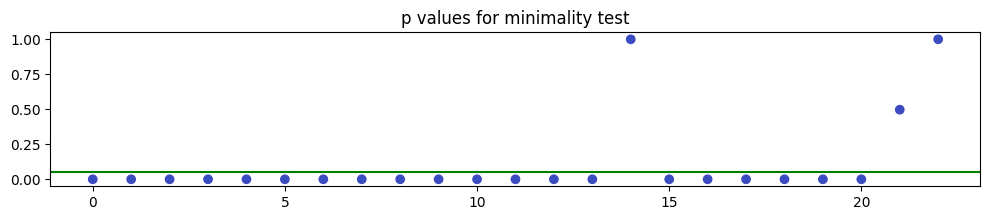

In [68]:
# plot p values as scatter plot
fig, ax = plot_p_values(min_test_results, tested_edges, edge_scores)


In [69]:
len(next(iter(min_test_results.values())).diffs)

2

(<Figure size 1200x200 with 1 Axes>,
 <Axes: title={'center': 'k for minimality test'}>)

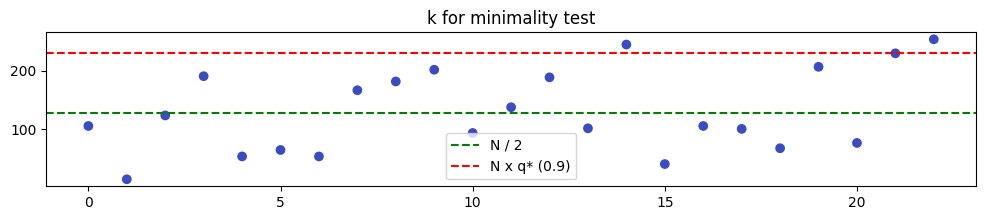

In [70]:
# plot frac of n 
plot_edge_k(min_test_results, tested_edges, edge_scores, task.batch_size * task.batch_count, q_star=q_star)


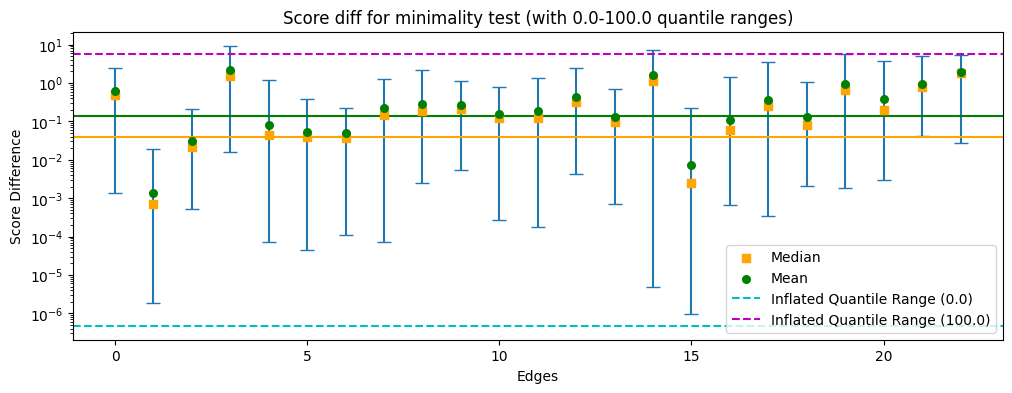

In [65]:
# plot average diff 
fit, ax = plot_score_quantiles(min_test_results, tested_edges, edge_scores, quantile_range=[0.00, 1.00])
